# Ciência dos Dados 2020 - Projeto 2
___
- Giovanni Rozatti
- Larissa Oliveira da Silva
___

<font color='#DF2535'>  
## Disclaimer$^{_1}$:  
  
A ideia de criar um notebook organizacional foi herdada do P3 feito por Giovanni Rozatti (em conjunto com Daniel G. Terra e Rafael B. Zanfolin) no semestre anterior, o repositório para esse notebook daquele projeto se encontra no link a seguir:`https://github.com/VonIgnia/C.Dados-P3/blob/master/Classificador2/_Fun%C3%A7%C3%B5es.ipynb`
- A ideia original pertence a Daniel Terra, e sua execução(no Projeto 3) foi feita em conjunto com Giovanni Rozatti
- A maior parte das funções nesse notebook é inédita
- Partes diretmente extraídas daquele serão antecedidas por outro disclaimer  
</font>

### Objetivos do Notebook:
- O principal propósito desse notebook é a hospedagem e organização das funções que serão utilizados nos outros notebooks desse projeto.  
- Outro propósito é uma breve explicação do funcionamento individual de cada uma delas

___
### Imports iniciais
- Importa bibliotecas e funções com que trabalharemos ao longo desse notebook

In [1]:
import pandas as pd
import numpy as np

In [2]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [3]:
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import matplotlib

In [4]:
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import *

___
### Dados
- Importa nossa base de dados

In [5]:
Dados=pd.read_csv('cars_Brazil_data.csv')

- Optamos por trabalhar apenas com carros que apareçam no Dataset no mínimo 500 vezes, esse valor foi escolhido de forma a separar o Dataset individual de cada carro em teste e treinamento, com 10% (no mínimo 50 linhas) do Dataset sendo direcionado para teste.   
    - <font color="#F02510"> **Observação 04/06: Talvez seja viável reduzir esse limite para 300, em contraponto o limite de 500 já fornece uma base de dados extensa o bastante e informações que parecem ser suficientes para elaborar uma conclusão.** </font>

In [6]:
#separa carros com mais de 500 ocorrências no Dataframe
Mais_de_500 = Dados['nome'].value_counts() > 500
Mais_de_500 = list(Mais_de_500.loc[Mais_de_500].index)
Dados = Dados.loc[Dados['nome'].isin(Mais_de_500),:];

#Converte as variáveis quali em quanti:
Dummies = pd.get_dummies(Dados.drop(columns='nome'), prefix=['marca', 'categoria','loc']).dropna()

#### Separando 10% do Dataframe global para treinamento
Nota para si mesmo: Estudar se faz sentido ou não eliminar as colunas nome do carro e marca 
<font color= "#DD3533">  
    
-  (Observação inicial 2 de junho: Não parece fazer)
- (Observação secundária 3 de junho: Talvez transformá-los em dummy ou hot-end)
   - Tentar Hot-End (Fiz o dummies por praticidade, checar depois. **Anotação 04/06**)
   - dummies está pronto (**Anotação 04/06**)
- Agora que `dummies` foi criado, analisar quais alterações deverão ser feitas nas funções  
(Aparentemente elas seguirão o mesmo formato visto na linha 10 da célula "Separando 10% do Dataframe de cada carro para treinamento:")
 </font>

In [7]:
# separa características dos carros, que podem ser relevantes no contexto de uma regrssão e \n
# elimina as características irrelevantes assim como a coluna com resultado esperado;
inputs = Dummies.drop(columns=["valor"])

#separa o resultado esperado, devemos calcular a previsão mais próxima a eles;
target = Dummies["valor"]

#separando dataframes teste e treino
X_train,X_test,Y_train,Y_test=tts(inputs,target,test_size=0.9)

#### Separando 10% do Dataframe de cada carro para treinamento:

In [8]:
Carro         = {}
Carro_inputs  = {}
Carro_target  = {}
Carro_X_train = {}
Carro_X_test  = {}
Carro_Y_train = {}
Carro_Y_test  = {}

for x in Mais_de_500:
    Carro[x] = Dummies.loc[Dados['nome'] == x]
        
    Carro_inputs[x] = Carro[x].drop(columns=["valor"])
    Carro_target[x] = Carro[x]["valor"]
        
    #separando dataframes teste e treino
    Carro_X_train[x],Carro_X_test[x],Carro_Y_train[x],Carro_Y_test[x]=tts(Carro_inputs[x],Carro_target[x],test_size=0.9)

In [9]:
#Usar essa informação com a função interact do ipywidgets
def Separa_dataframe_por_carro(x):
    return (Carro_X_train[x],Carro_X_test[x],Carro_Y_train[x],Carro_Y_test[x])

In [10]:
#interact (Separa_dataframe_por_carro, x=Mais_de_500)

___
### Funções de Filtragem e Separação dos dados

In [11]:
#Usar essa informação com a função interact do ipywidgets
#alterar as dimensões do scatter plot (quase que certamente valor não depende exclusivamente dos km_rodados)
def Dispersão_individual_por_veículo(x):
    gráfico_de_dispersão  = plt.scatter (Dummies.loc[Dados['nome'] == x]['valor'],Dummies.loc[Dados['nome'] == x]['km_rodados'])
    return gráfico_de_dispersão

In [12]:
interact (Dispersão_individual_por_veículo, x=Mais_de_500)

interactive(children=(Dropdown(description='x', options=('CHEVROLET ONIX', 'RENAULT SANDERO', 'FORD KA', 'HYUN…

<function __main__.Dispersão_individual_por_veículo(x)>

In [13]:
cmap = matplotlib.cm.get_cmap('Spectral')

def Dispersão_global_por_veículo(lista):
    t=0
    for x in lista:
        plt.scatter (Dummies.loc[Dados['nome'] == x]['valor'],Dummies.loc[Dados['nome'] == x]['km_rodados'],
                 label=x, c=[cmap(t * 1/(len(lista)-1))]) 
        t+=1
        #Acrescentar um sistema de arange de cores (colormap?)
        plt.legend();

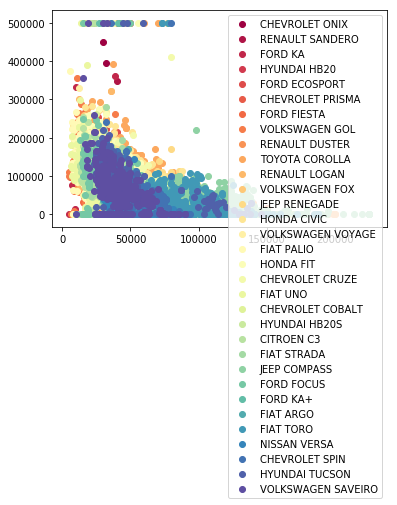

In [14]:
Dispersão_global_por_veículo(Mais_de_500);

___
### Modelos de Regressão e Classificação pré-processados do sklearn

#### Random Forest Regressor (da Biblioteca SKLearn)

In [15]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(max_depth=12,n_estimators=50,random_state=0)
# Apesar do valor default do random_state ser None, ainda haviam varaiações de resultados quando o modelo
# era rodado(sem alterar a base de treinamento), isso foi solucionado ao trocar o valor por 0
model.fit(X_train,Y_train);

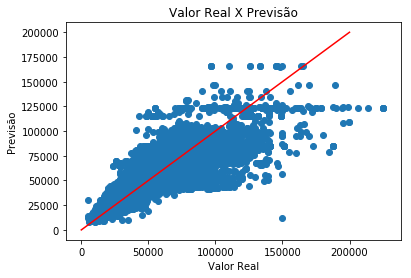

0.7010782233297436


In [16]:
############################################################################################
############################################################################################

Y_predict = model.predict(X_test) #Faz a previsão dos valores de Y dados os valores de X
###
plt.plot(np.arange(0,200000),np.arange(0,200000), color='red')
plt.scatter(Y_test,Y_predict)
plt.title("Valor Real X Previsão")
plt.xlabel("Valor Real")
plt.ylabel("Previsão")
plt.show()
###
print(model.score(X_test,Y_test)) and ("acurácia do modelo: {0:.2f}%".format(acurácia*100))

###Excluir essa célula após trocar os plots por figs em Random_Forest_geral e Random_Forest_individual###
#Acrescentar margem de erro de {1 a 10%}, {variância dos preços} do valor individual de cada veículo

#############################################################################################
#############################################################################################

In [17]:
def Random_Forest_geral():
    model = RandomForestRegressor(max_depth=12,n_estimators=50,random_state=0)
    model.fit(X_train,Y_train)
    acurácia  = model.score(X_test,Y_test)
    Y_predict = model.predict(X_test)
    return (plt.scatter(Y_test,Y_predict)) and ("acurácia do modelo: {0:.2f}%".format(acurácia*100))

In [18]:
def Random_Forest_individual(x):
    model.fit(Separa_dataframe_por_carro(x)[0],Separa_dataframe_por_carro(x)[2])
    acurácia = model.score(Separa_dataframe_por_carro(x)[1],Separa_dataframe_por_carro(x)[3])
    Carro_Y_predict = {}
    Carro_Y_predict[x] = model.predict(Carro_X_test[x])
    return (plt.scatter(Carro_Y_test[x],Carro_Y_predict[x])) and ("acurácia do modelo: {0:.2f}%".format(acurácia*100))

___

In [19]:
interact(Random_Forest_individual,x=Mais_de_500);

interactive(children=(Dropdown(description='x', options=('CHEVROLET ONIX', 'RENAULT SANDERO', 'FORD KA', 'HYUN…